# 1.5 Global Volume / Dollar Bars

In the text "Advances in Financial Machine Learning", author Marcos Lopez de Prado introduces the idea of information driven bars. He shows that bars with the basis of time as a discrete unit to not produce gaussian returns. However, bars with units of Volume do show guassian returns. Because of this, machine learning may struggle to find relationships in time bars, but might do significantly better with volume bars. 

De Prado goes further to discuss Dollar Bars, where the volume of a security is multiplied by the value of the underlying to produce a quantification of the amount of actual value being exchanged. I will investigate this kind of bar in this notebook, and attempt to apply it on a global-market scale. For now, "Global" will be defined as the SP500 index of stocks. However, in the future I will strive to define "Global" as truly global. The end goal will encompass the highest market cap stocks on exchanges around the world, currencies, and commodities. 

The goal of this kind of modeling is indeed to produce a model that traces the movement of all value globally. Of course, I cannot model every single instrument, so I will limit my pursuit to only those instruments that represent a large relative portion of trading value on a single day. 

In this notebook, we will look at the SP500 as a limited scope. We will seek to answer the questions:

- How much total value is traded on a single day in the SP500? 
- What is a good quantization of this value for a single bar?
- How can we transform the underlying time bars to represent dollar bars? 
- Once the transformation is complete, can we find any correlations in the market data? 

#### Transform SP500 Market Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sp = pd.read_csv('../data/S&P500-Symbols.csv').drop('Unnamed: 0', axis=1)
sp.head()

Symbol
0    MMM
1    ABT
2   ABBV
3   ABMD
4    ACN

In [2]:
df = pd.read_csv('../data/sp500/sp500_minute_data.csv')
df.head()

datetime  MMM_open  MMM_high  MMM_low  MMM_close  MMM_volume  \
0  2020-08-17 08:00:00       NaN       NaN      NaN        NaN         NaN   
1  2020-08-17 08:01:00       NaN       NaN      NaN        NaN         NaN   
2  2020-08-17 08:02:00       NaN       NaN      NaN        NaN         NaN   
3  2020-08-17 08:03:00       NaN       NaN      NaN        NaN         NaN   
4  2020-08-17 08:04:00       NaN       NaN      NaN        NaN         NaN   

   ABT_open  ABT_high  ABT_low  ABT_close  ...  ZION_open  ZION_high  \
0       NaN       NaN      NaN        NaN  ...        NaN        NaN   
1       NaN       NaN      NaN        NaN  ...        NaN        NaN   
2       NaN       NaN      NaN        NaN  ...        NaN        NaN   
3       NaN       NaN      NaN        NaN  ...        NaN        NaN   
4       NaN       NaN      NaN        NaN  ...        NaN        NaN   

   ZION_low  ZION_close  ZION_volume  ZTS_open  ZTS_high  ZTS_low  ZTS_close  \
0       NaN         NaN          NaN       NaN       NaN      NaN        NaN   
1       NaN         NaN          NaN       NaN       NaN      NaN        NaN   
2       NaN         NaN          NaN       NaN       NaN      NaN        NaN   
3       NaN         NaN          NaN       NaN       NaN      NaN        NaN   
4       NaN         NaN          NaN       NaN       NaN      NaN        NaN   

   ZTS_volume  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  

[5 rows x 2526 columns]

In [3]:
df.shape

(19729, 2526)

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [5]:
df.loc[:, df.columns[df.columns.str.contains('volume')]] = df.loc[:, df.columns[df.columns.str.contains('volume')]].fillna(0)

In [6]:
df.loc[:, df.columns[~df.columns.str.contains('volume')]] = df.loc[:, df.columns[~df.columns.str.contains('volume')]].fillna(method='ffill')

In [7]:
df.tail(100)

MMM_open  MMM_high  MMM_low  MMM_close  MMM_volume  \
datetime                                                                  
2020-09-15 18:52:00  166.6200  166.7000   166.62     166.70       825.0   
2020-09-15 18:53:00  166.7017  166.7114   166.67     166.67      1953.0   
2020-09-15 18:54:00  166.6600  166.6600   166.65     166.66       801.0   
2020-09-15 18:55:00  166.6300  166.6387   166.59     166.59       613.0   
2020-09-15 18:56:00  166.5700  166.5700   166.53     166.54      2198.0   
...                       ...       ...      ...        ...         ...   
2020-09-15 20:27:00  166.5000  166.5000   166.50     166.50         0.0   
2020-09-15 20:28:00  166.5000  166.5000   166.50     166.50         0.0   
2020-09-15 20:29:00  166.5000  166.5000   166.50     166.50         0.0   
2020-09-15 20:30:00  166.5000  166.5000   166.50     166.50         0.0   
2020-09-15 20:31:00  166.5000  166.5000   166.50     166.50         0.0   

                     ABT_open  ABT_high  ABT_low  ABT_close  ABT_volume  ...  \
datetime                                                                 ...   
2020-09-15 18:52:00   106.755  106.7700  106.740   106.7400      2008.0  ...   
2020-09-15 18:53:00   106.745  106.7600  106.740   106.7400      1944.0  ...   
2020-09-15 18:54:00   106.750  106.7826  106.745   106.7826      1613.0  ...   
2020-09-15 18:55:00   106.810  106.8200  106.780   106.7800      3422.0  ...   
2020-09-15 18:56:00   106.780  106.8282  106.780   106.8242      1550.0  ...   
...                       ...       ...      ...        ...         ...  ...   
2020-09-15 20:27:00   106.580  106.5800  106.580   106.5800         0.0  ...   
2020-09-15 20:28:00   106.580  106.5800  106.580   106.5800         0.0  ...   
2020-09-15 20:29:00   106.580  106.5800  106.580   106.5800         0.0  ...   
2020-09-15 20:30:00   106.580  106.5800  106.580   106.5800         0.0  ...   
2020-09-15 20:31:00   106.580  106.5800  106.580   106.5800         0.0  ...   

                     ZION_open  ZION_high  ZION_low  ZION_close  ZION_volume  \
datetime                                                                       
2020-09-15 18:52:00    31.4000    31.4200   31.4000     31.4200       1100.0   
2020-09-15 18:53:00    31.4150    31.4150   31.4050     31.4100        900.0   
2020-09-15 18:54:00    31.4000    31.4000   31.3700     31.3700       1000.0   
2020-09-15 18:55:00    31.3700    31.3800   31.3700     31.3800        929.0   
2020-09-15 18:56:00    31.3800    31.3850   31.3400     31.3850       6955.0   
...                        ...        ...       ...         ...          ...   
2020-09-15 20:27:00    31.4029    31.4029   31.4029     31.4029          0.0   
2020-09-15 20:28:00    31.4029    31.4029   31.4029     31.4029          0.0   
2020-09-15 20:29:00    31.4029    31.4029   31.4029     31.4029          0.0   
2020-09-15 20:30:00    31.4029    31.4029   31.4029     31.4029          0.0   
2020-09-15 20:31:00    31.4029    31.4029   31.4029     31.4029          0.0   

                     ZTS_open  ZTS_high  ZTS_low  ZTS_close  ZTS_volume  
datetime                                                                 
2020-09-15 18:52:00   162.415    162.49  162.410    162.430      3006.0  
2020-09-15 18:53:00   162.430    162.46  162.387    162.415      2448.0  
2020-09-15 18:54:00   162.450    162.48  162.420    162.480      1000.0  
2020-09-15 18:55:00   162.480    162.56  162.480    162.510      2400.0  
2020-09-15 18:56:00   162.510    162.53  162.450    162.530      2563.0  
...                       ...       ...      ...        ...         ...  
2020-09-15 20:27:00   162.280    162.28  162.280    162.280      3951.0  
2020-09-15 20:28:00   162.280    162.28  162.280    162.280         0.0  
2020-09-15 20:29:00   162.280    162.28  162.280    162.280         0.0  
2020-09-15 20:30:00   162.280    162.28  162.280    162.280         0.0  
2020-09-15 20:31:00   162.280    162.28  162.280    162.280         0.0  



In [8]:
#### Consider only volume

vol_df = df[df.columns[df.columns.str.contains('volume')]]

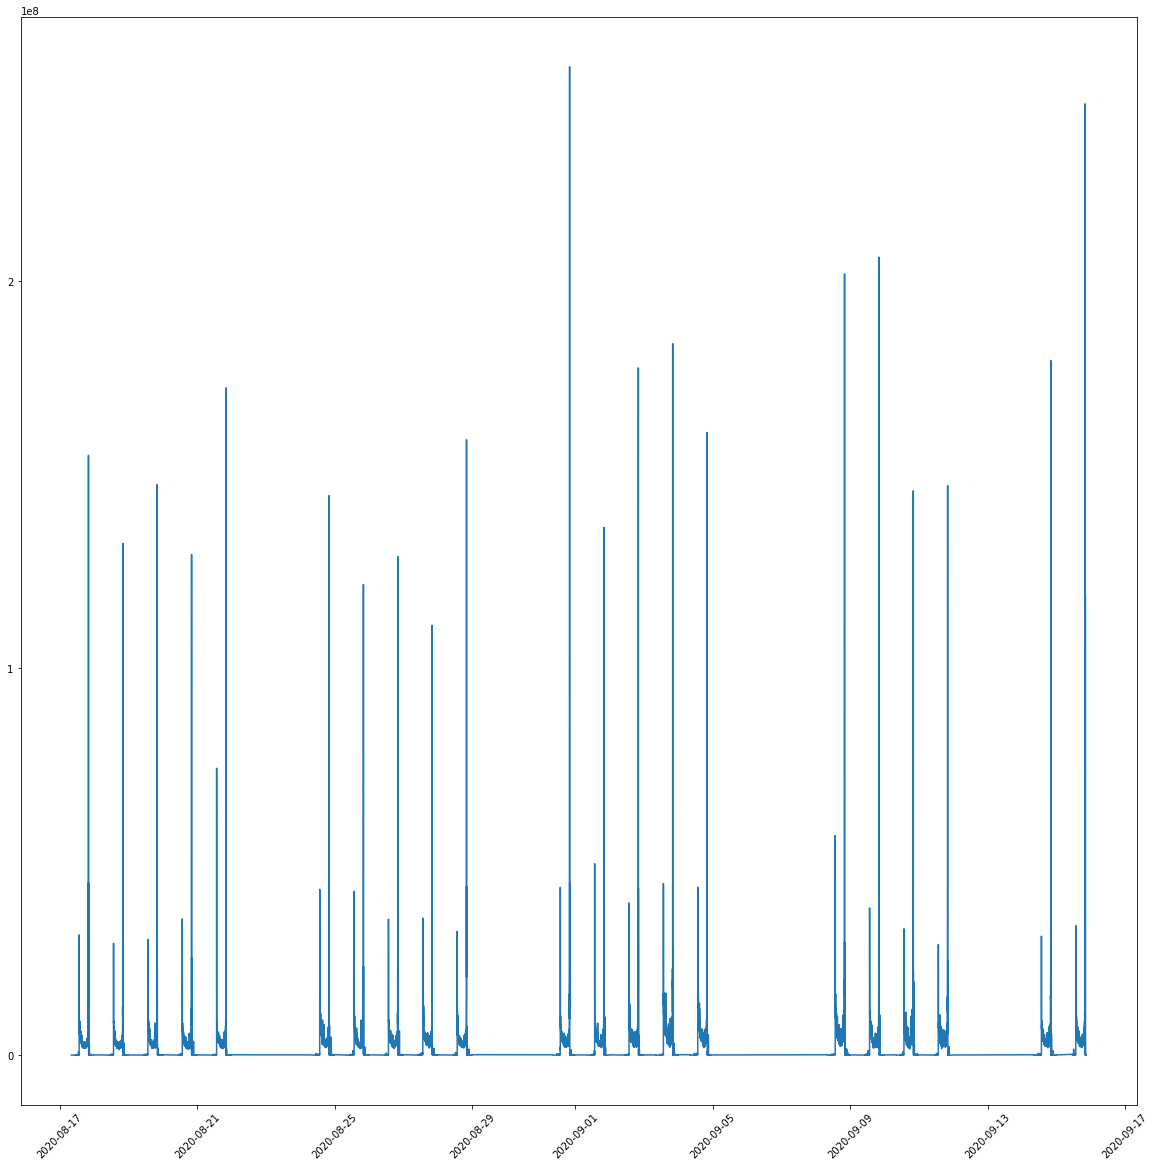

In [9]:
plt.figure(figsize=(20,20))
plt.locator_params(nbins=5)
plt.xticks(rotation=45)
plt.plot(vol_df.sum(axis=1))

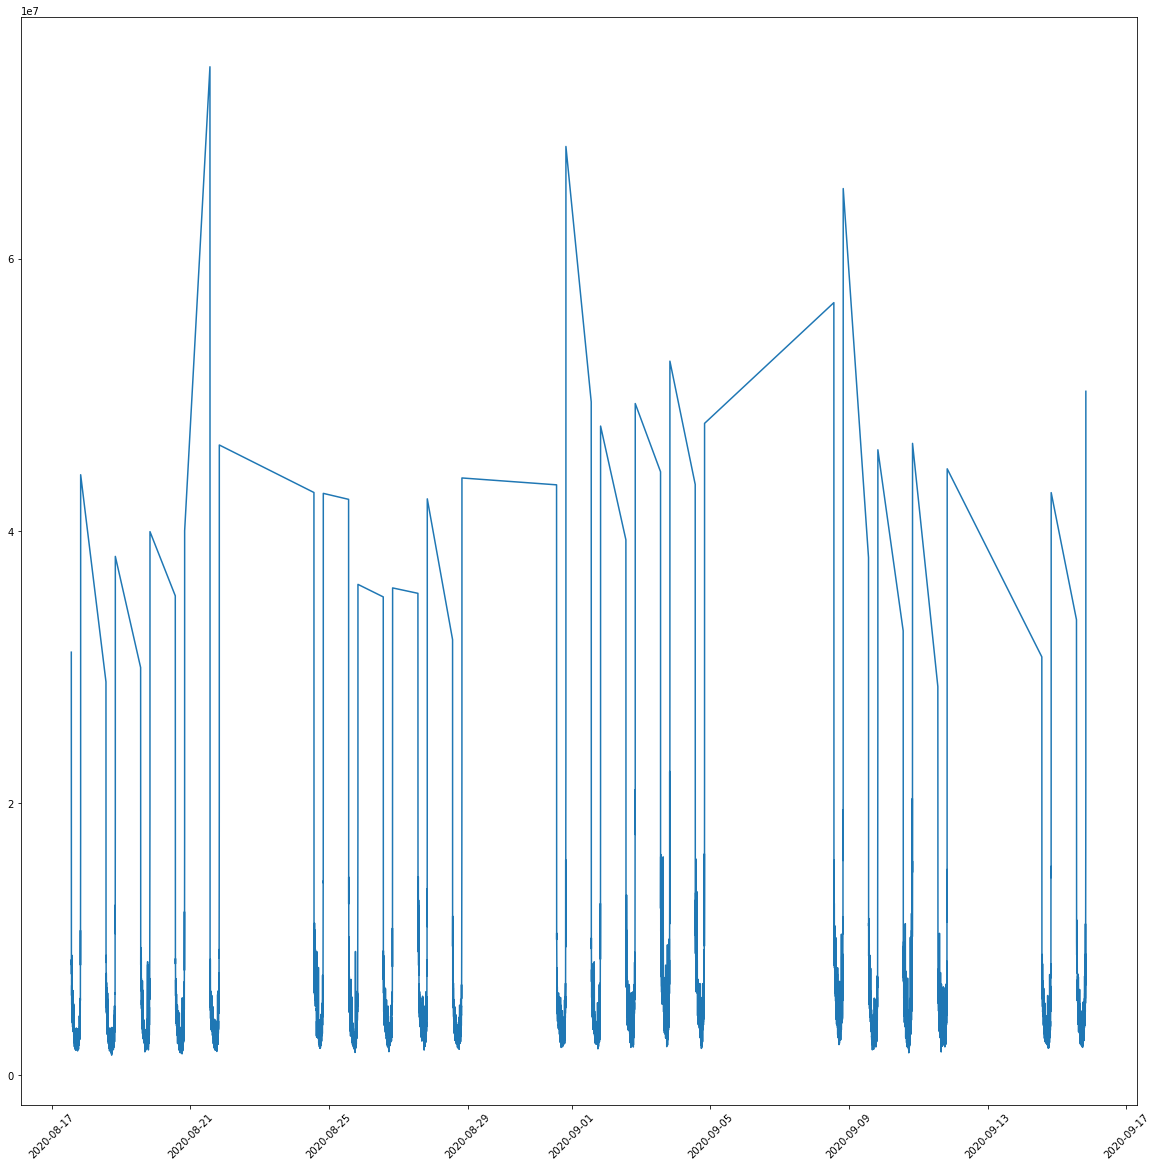

In [10]:
h13 = vol_df.index.hour > 13
h20 = vol_df.index.hour < 20
m30 = vol_df.index.minute >= 30
h12 = vol_df.index.hour > 12

plt.figure(figsize=(20,20))
plt.locator_params(nbins=5)
plt.xticks(rotation=45)
plt.plot(vol_df[h20 & (h13 | (h12 & m30))].sum(axis=1))

Text(0.5, 1.0, 'Volume 9/15 by minute')

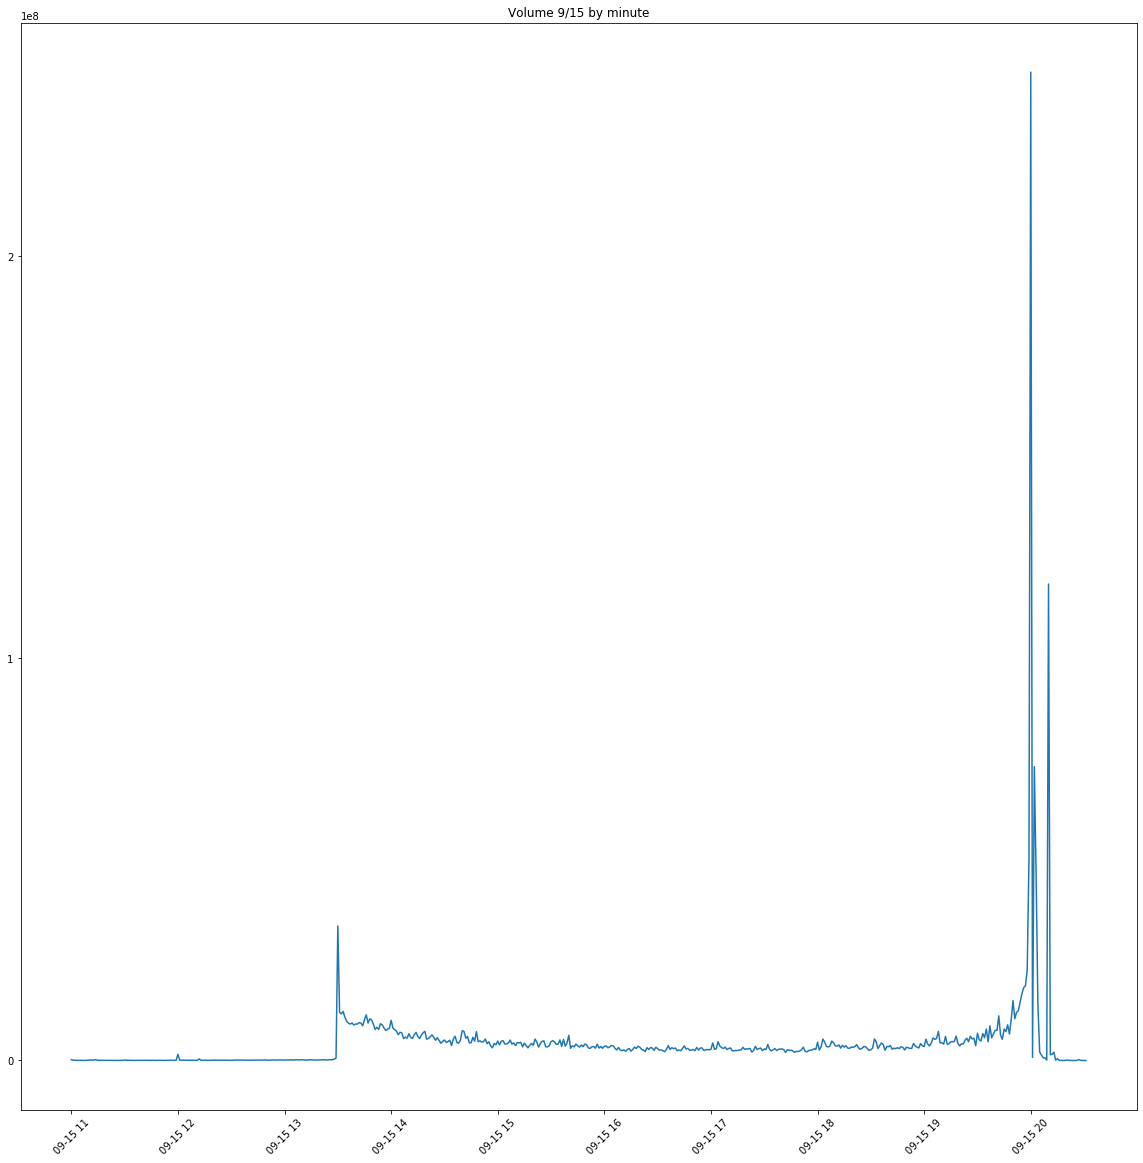

In [133]:
plt.figure(figsize=(20,20))
plt.locator_params(nbins=5)
plt.xticks(rotation=45)
plt.plot(vol_df[vol_df.index.day == 15].sum(axis=1))
plt.title('Volume 9/15 by minute')

Surprisingly, the largest amount of volume consistently happens in the afternoon posterior to market close. There is also a large spike every day on market open. 

In considering what to do with volume after market close, we need to be mindful of two aspects. First, can we trade while the market is closed? Second, do after hours trades affect the price of instruments?

Unfortunately, the answer to the first question is no while the answer to the second question is definitely yes. Because the answer to the second question is yes, we must leave this data in the model. Unfortunately, we will not currently be able to make use of it. 

On the other hand, because we will group time by dollar volume, we do not need to worry about the long periods of zero volume. They should disappear naturally once we change the encoding. 

In [12]:
vol_df.sum(axis=1).describe()

count    1.972900e+04
mean     2.230566e+06
std      6.609704e+06
min      1.000000e+02
25%      1.525600e+04
50%      8.586700e+04
75%      3.301421e+06
max      2.553862e+08
dtype: float64

In [13]:
vol_df.sum(axis=1)

datetime
2020-08-17 08:00:00     27994.0
2020-08-17 08:01:00     11425.0
2020-08-17 08:02:00      4973.0
2020-08-17 08:03:00      9992.0
2020-08-17 08:04:00     17819.0
                         ...   
2020-09-15 20:27:00    247822.0
2020-09-15 20:28:00     54176.0
2020-09-15 20:29:00      2273.0
2020-09-15 20:30:00     15016.0
2020-09-15 20:31:00       145.0
Length: 19729, dtype: float64

In [14]:
1e4

10000.0

Text(0.5, 1.0, 'Volume 9/15 Excluding minutes w/ volume > 1e7')

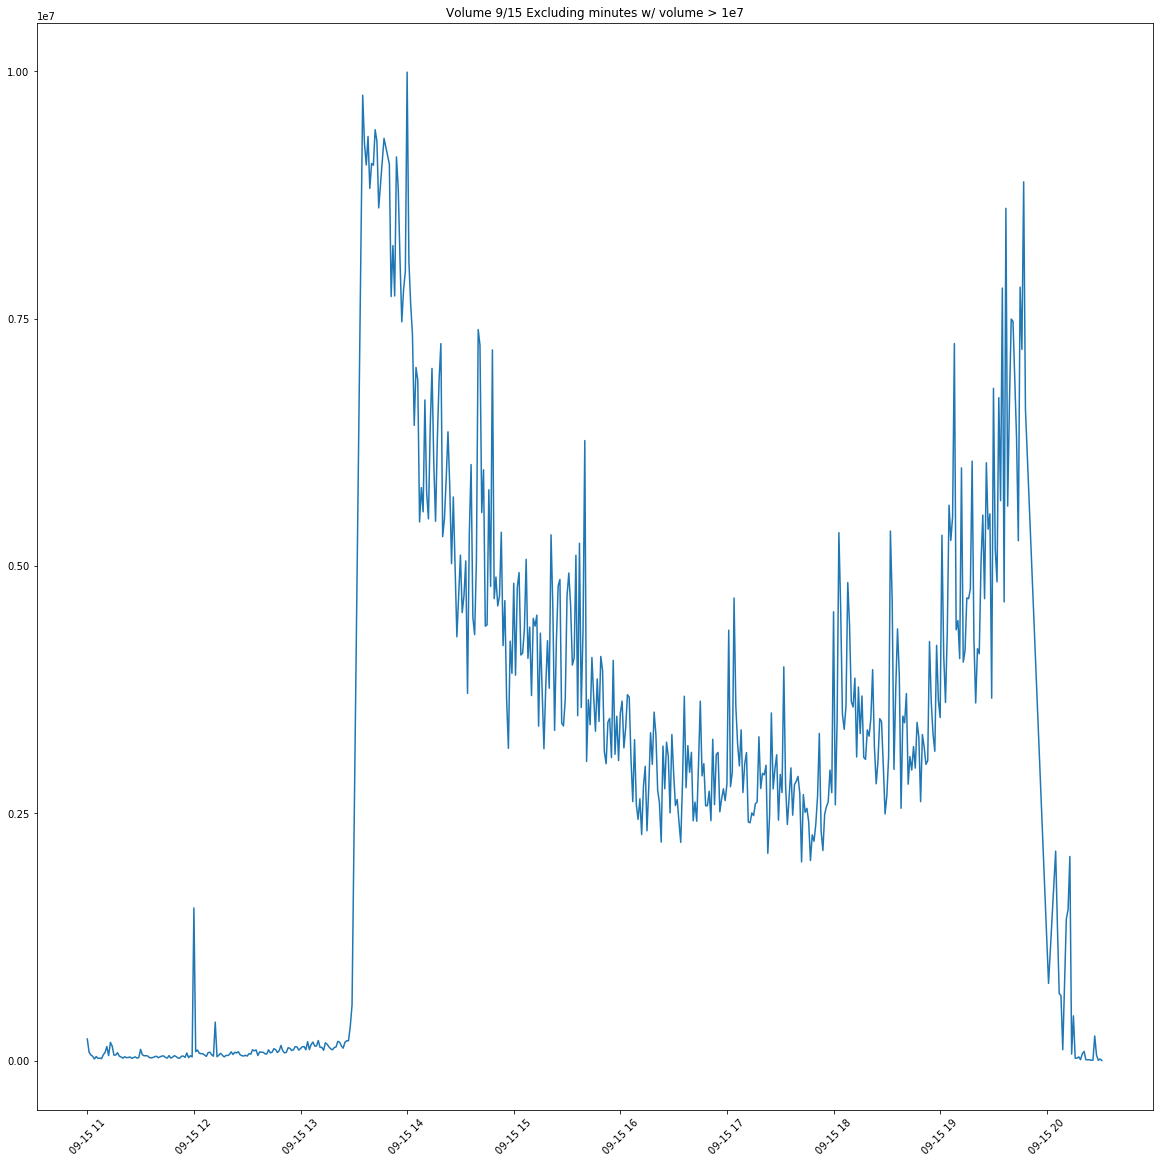

In [132]:
plt.figure(figsize=(20,20))
plt.locator_params(nbins=5)
plt.xticks(rotation=45)
plt.plot(vol_df[(vol_df.sum(axis=1) < 1e7) & (vol_df.index.day == 15)].sum(axis=1))
plt.title('Volume 9/15 Excluding minutes w/ volume > 1e7')

In [138]:
day_trade_vol = vol_df[(h20 & (h13 | (h12 & m30))) & (vol_df.index.day == 15)].sum(axis=1).sum()
day_trade_vol

1907537944.0

In [146]:
1.9e9

1900000000.0

In [139]:
all_day_vol = vol_df[vol_df.index.day == 15].sum(axis=1).sum()
all_day_vol

2432363121.0

In [145]:
2.4e9

2400000000.0

In [140]:
after_hours_vol = all_day_vol - day_trade_vol
after_hours_vol

524825177.0

In [143]:
5.2e8

520000000.0

In [147]:
after_hours_vol / all_day_vol

0.21576760988886906

Challenge: write an algorithm that changes time bars to volume and/or dollar bars 

First, we have only looked at volume so far. What if we look at daily value exchanged by minute? 

In [127]:
for sym in sp['Symbol']:
    df[f'{sym}_value_close'] = df[f'{sym}_volume'] * df[f'{sym}_close']

cols = df.columns.str.contains('_value_close')
cols

array([False, False, False, ..., False, False, False])

In [128]:
df[df.columns[cols]].sum(axis=1)

0        1.804312e+06
1        4.433228e+05
2        3.494197e+05
3        2.974451e+05
4        1.003737e+06
             ...     
19724    2.167994e+07
19725    5.310754e+06
19726    2.603237e+05
19727    1.181363e+06
19728    1.415153e+04
Length: 19729, dtype: float64

In [129]:
df.columns[cols]

Index(['MMM_value_close', 'ABT_value_close', 'ABBV_value_close',
       'ABMD_value_close', 'ACN_value_close', 'ATVI_value_close',
       'ADBE_value_close', 'AMD_value_close', 'AAP_value_close',
       'AES_value_close',
       ...
       'WYNN_value_close', 'XEL_value_close', 'XRX_value_close',
       'XLNX_value_close', 'XYL_value_close', 'YUM_value_close',
       'ZBRA_value_close', 'ZBH_value_close', 'ZION_value_close',
       'ZTS_value_close'],
      dtype='object', length=505)

Text(0.5, 1.0, 'Dollar Volume')

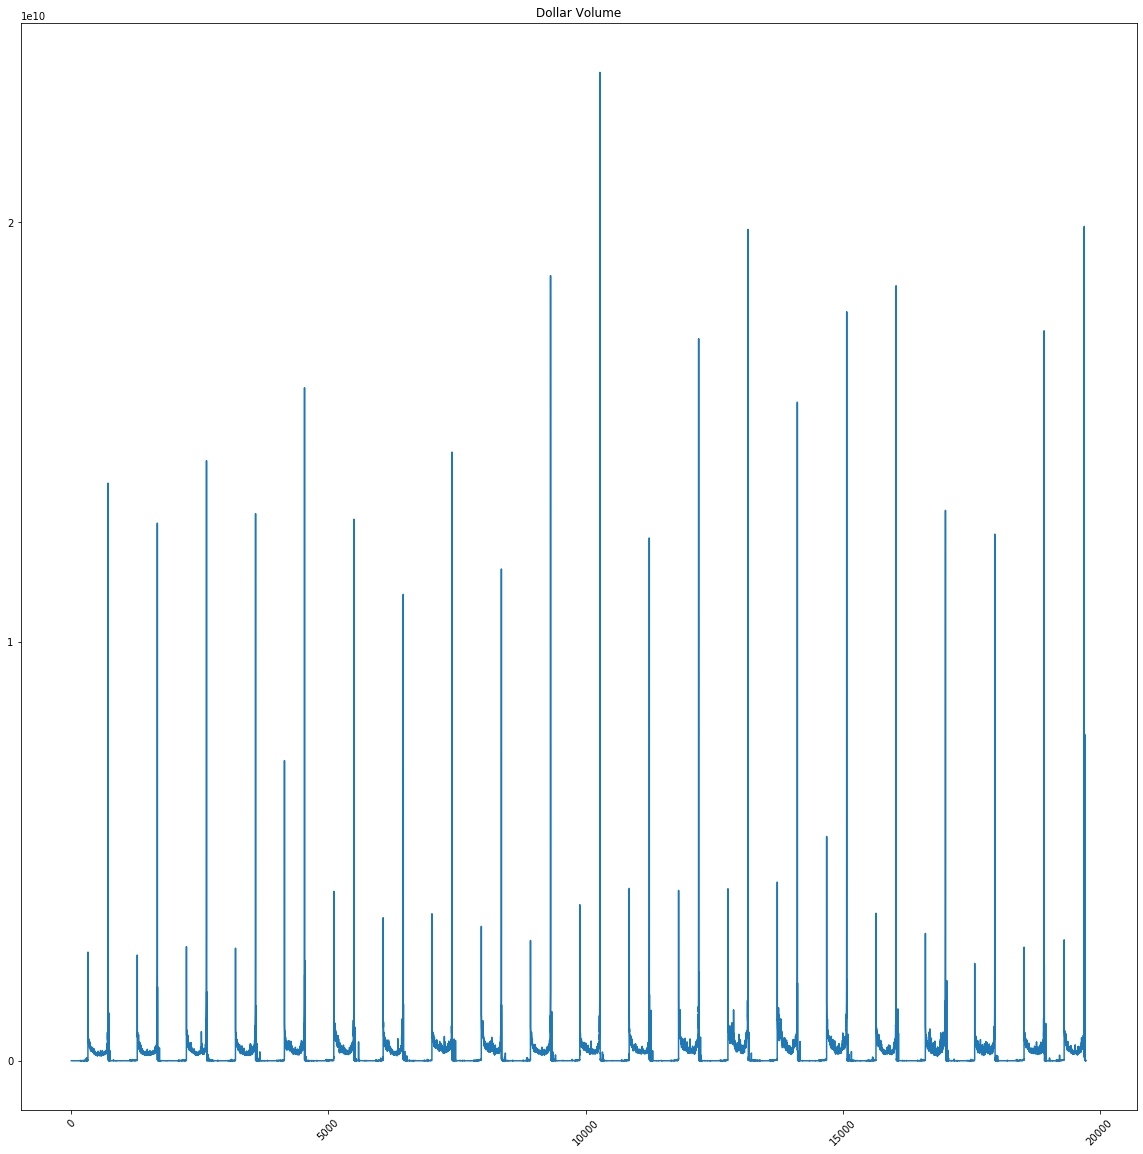

In [130]:
plt.figure(figsize=(20,20))
plt.locator_params(nbins=5)
plt.xticks(rotation=45)
plt.plot(df[df.columns[cols]].sum(axis=1))
plt.title('Dollar Volume')

In [20]:
value_df = df[df.columns[cols]].sum(axis=1)
value_df.shape

(19729,)

In [21]:
value_df[value_df.index.day == 15]

datetime
2020-09-15 11:00:00    2.130321e+07
2020-09-15 11:01:00    1.078915e+07
2020-09-15 11:02:00    8.597688e+06
2020-09-15 11:03:00    7.684807e+06
2020-09-15 11:04:00    2.712824e+06
                           ...     
2020-09-15 20:27:00    2.167994e+07
2020-09-15 20:28:00    5.310754e+06
2020-09-15 20:29:00    2.603237e+05
2020-09-15 20:30:00    1.181363e+06
2020-09-15 20:31:00    1.415153e+04
Length: 572, dtype: float64

Text(0.5, 1.0, 'Dollar Volume on Sep 15')

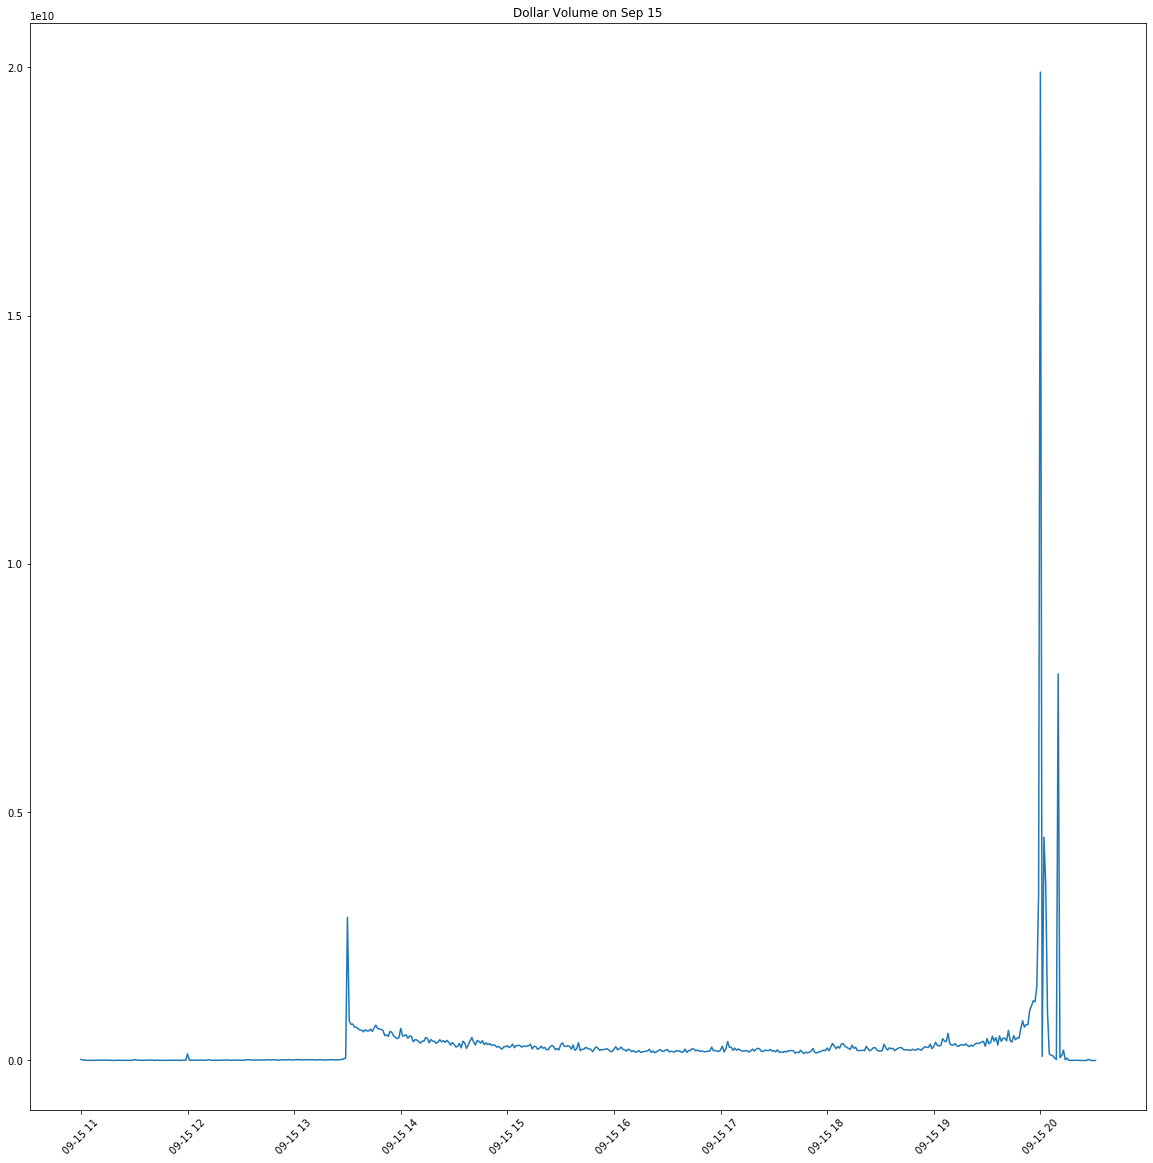

In [154]:
plt.figure(figsize=(20,20))
plt.locator_params(nbins=5)
plt.xticks(rotation=45)
plt.plot(value_df[value_df.index.day == 15])
plt.title('Dollar Volume on Sep 15')

In [160]:
value_df = pd.DataFrame(value_df)

In [161]:
h13 = value_df.index.hour > 13
h20 = value_df.index.hour < 20
m30 = value_df.index.minute >= 30
h12 = value_df.index.hour > 12




127642331607.11157

In [164]:
day_trade_val = value_df[(h20 & (h13 | (h12 & m30))) & (value_df.index.day == 15)].sum(axis=1).sum()
all_day_val = value_df[value_df.index.day == 15].sum(axis=1).sum()
after_hours_val = all_day_val - day_trade_val
print(f'Day {day_trade_val}')
print(f'All {all_day_val}')
print(f'Aft {after_hours_val}')
print(f'Af% {after_hours_val/all_day_val}')

Day 127642331607.11157
All 166769868357.8918
Aft 39127536750.78024
Af% 0.23461994145616094


In [23]:
value_df.describe()

count    1.972900e+04
mean     1.676852e+08
std      5.849448e+08
min      6.080000e+02
25%      1.173722e+06
50%      7.468689e+06
75%      2.437587e+08
max      2.357890e+10
dtype: float64

In [169]:
# dollar volume during day trading on sep 15
dv_sep15_day = value_df[(h20 & (h13 | (h12 & m30))) & (value_df.index.day == 15)].sum(axis=1)

# randomly sample and sum 3 or 4 minutes to get a good baseline for trade frequency to start 
min_3_samp = np.random.choice(dv_sep15_day, size=3, replace=False).sum()
min_4_samp = np.random.choice(dv_sep15_day, size=4, replace=False).sum()

print(f'3 minutes {min_3_samp}. 4 minutes {min_4_samp}.')

3 minutes 675948687.6588. 4 minutes 1429907670.7626998.


In [173]:
dv_sep15_day.describe()

count    3.900000e+02
mean     3.272880e+08
std      2.622110e+08
min      1.387807e+08
25%      2.048268e+08
50%      2.636002e+08
75%      3.633397e+08
max      3.366607e+09
dtype: float64

Text(0.5, 0, 'Value traded per minute, Billions $')

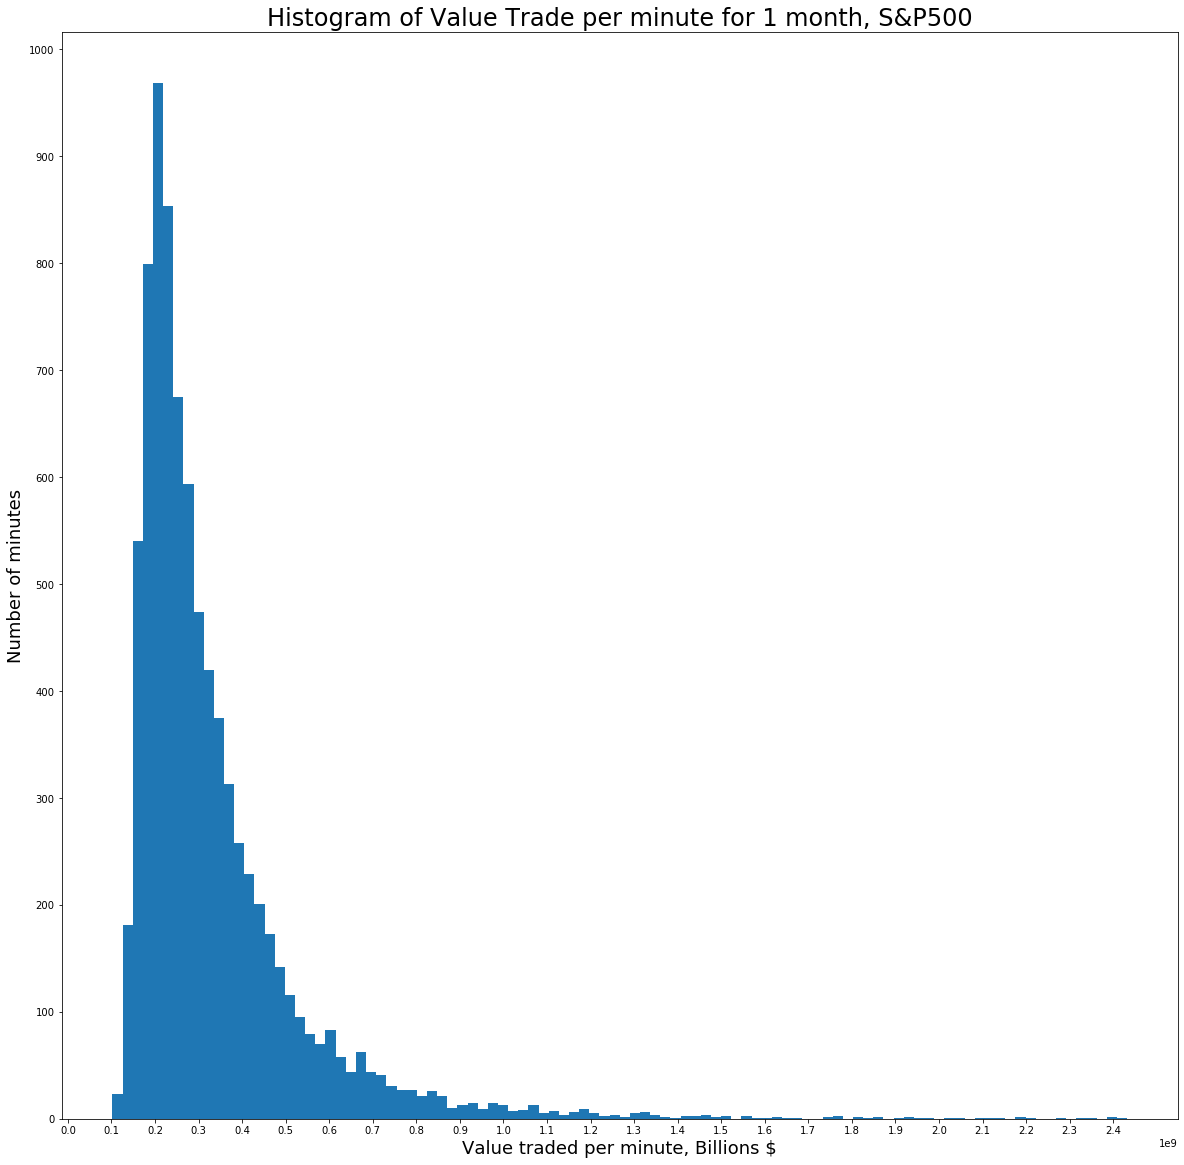

In [24]:
plt.figure(figsize=(20,20))
plt.xticks(np.arange(0, .25e10, step=.01e10))
plt.yticks(np.arange(0,12000, step=100))
hist = plt.hist(value_df[(value_df < .25e10) & (value_df > 1e8)], bins=100)
plt.title('Histogram of Value Trade per minute for 1 month, S&P500', size=24)
plt.ylabel('Number of minutes', size=18)
plt.xlabel('Value traded per minute, Billions $', size=18)

The histogram above shows that on any minute of any given day, the value being traded is distributed around 250 million dollars, with a very long right tail produced a huge left skew. 

Cut off from the graph are minutes which saw < \\$100 million in value transferred, which are assumed to be outside market hours. Also cut from the graph are minutes which saw > \\$2.5 billion, which are likewise assumed to happen mostly at the end of the day afte close. 

Given that the majority of trading minutes represent value flows of \\$100 million to \\$1 billion dollars, let's consider encoding our data in \\$100 million value segments. 

In [25]:
# how would we even do such a thing ?
df['total_value'] = df[df.columns[cols]].sum(axis=1)
df['total_value']

datetime
2020-08-17 08:00:00    1.804312e+06
2020-08-17 08:01:00    4.433228e+05
2020-08-17 08:02:00    3.494197e+05
2020-08-17 08:03:00    2.974451e+05
2020-08-17 08:04:00    1.003737e+06
                           ...     
2020-09-15 20:27:00    2.167994e+07
2020-09-15 20:28:00    5.310754e+06
2020-09-15 20:29:00    2.603237e+05
2020-09-15 20:30:00    1.181363e+06
2020-09-15 20:31:00    1.415153e+04
Name: total_value, Length: 19729, dtype: float64

In [26]:
df['cum_total_value'] = df['total_value'].cumsum()

In [27]:
df['cum_total_value']

datetime
2020-08-17 08:00:00    1.804312e+06
2020-08-17 08:01:00    2.247635e+06
2020-08-17 08:02:00    2.597055e+06
2020-08-17 08:03:00    2.894500e+06
2020-08-17 08:04:00    3.898237e+06
                           ...     
2020-09-15 20:27:00    3.308255e+12
2020-09-15 20:28:00    3.308260e+12
2020-09-15 20:29:00    3.308261e+12
2020-09-15 20:30:00    3.308262e+12
2020-09-15 20:31:00    3.308262e+12
Name: cum_total_value, Length: 19729, dtype: float64

In [194]:
df['cum_value_interval'] = pd.cut(df['cum_total_value'], pd.interval_range(start=0, end=df['cum_total_value'].max(), freq=4e8))

In [149]:
df.reset_index(inplace=True)

In [150]:
df['datetime'].isna()

0        False
1        False
2        False
3        False
4        False
         ...  
19724    False
19725    False
19726    False
19727    False
19728    False
Name: datetime, Length: 19729, dtype: bool

In [101]:
df['datetime'].isna().any()

False

In [112]:
df[df['cum_value_interval'] == df['cum_value_interval'].iloc[0]]

datetime  MMM_open  MMM_high  MMM_low  MMM_close  MMM_volume  \
0 2020-08-17 08:00:00       NaN       NaN      NaN        NaN         0.0   

   ABT_open  ABT_high  ABT_low  ABT_close  ...  XLNX_value_close  \
0       NaN       NaN      NaN        NaN  ...               NaN   

   XYL_value_close  YUM_value_close  ZBRA_value_close  ZBH_value_close  \
0              NaN              NaN               NaN              NaN   

   ZION_value_close  ZTS_value_close  total_value  cum_total_value  \
0               NaN              NaN   1804312.21       1804312.21   

       cum_value_interval  
0  (1000000.0, 2000000.0]  

[1 rows x 3034 columns]

In [103]:
df['datetime'].isna().sum()

0

In [195]:
df['cum_value_interval'].shape

(19729,)

In [196]:
df['cum_value_interval'].unique()

[(0.0, 400000000.0], (400000000.0, 800000000.0], (3200000000.0, 3600000000.0], (4000000000.0, 4400000000.0], (4400000000.0, 4800000000.0], ..., (3298400000000.0, 3298800000000.0], (3299200000000.0, 3299600000000.0], (3299600000000.0, 3300000000000.0], (3307600000000.0, 3308000000000.0], NaN]
Length: 6045
Categories (6044, interval[float64]): [(0.0, 400000000.0] < (400000000.0, 800000000.0] < (3200000000.0, 3600000000.0] < (4000000000.0, 4400000000.0] ... (3298400000000.0, 3298800000000.0] < (3299200000000.0, 3299600000000.0] < (3299600000000.0, 3300000000000.0] < (3307600000000.0, 3308000000000.0]]

In [152]:
df['cum_val_int_str'] = df['cum_value_interval'].astype('str')

In [201]:
df.groupby('cum_val_int_str')['datetime'].first().rename('open_datetime').shape

(8778,)

In [202]:
datetime_column = df.groupby('cum_value_interval')['datetime'].first().rename('open_datetime')

In [203]:
datetime_column.isna().sum()

2226

In [204]:
datetime_column.shape

(8270,)

In [29]:
df.groupby('cum_value_interval')['MMM_close'].last()

cum_value_interval
(0.0, 100000000.0]                    166.50
(100000000.0, 200000000.0]            166.70
(200000000.0, 300000000.0]            166.12
(300000000.0, 400000000.0]            166.46
(400000000.0, 500000000.0]            166.46
                                       ...  
(3307700000000.0, 3307800000000.0]    166.50
(3307800000000.0, 3307900000000.0]    166.50
(3307900000000.0, 3308000000000.0]    166.50
(3308000000000.0, 3308100000000.0]       NaN
(3308100000000.0, 3308200000000.0]    166.50
Name: MMM_close, Length: 33082, dtype: float64

In [30]:
df.groupby('cum_value_interval')[['MMM_volume','ABT_volume']].sum()

MMM_volume  ABT_volume
cum_value_interval                                        
(0.0, 100000000.0]                      1051.0         0.0
(100000000.0, 200000000.0]               806.0         0.0
(200000000.0, 300000000.0]               403.0         0.0
(300000000.0, 400000000.0]               240.0         0.0
(400000000.0, 500000000.0]                 0.0      4100.0
...                                        ...         ...
(3307700000000.0, 3307800000000.0]         0.0         0.0
(3307800000000.0, 3307900000000.0]         0.0         0.0
(3307900000000.0, 3308000000000.0]         0.0         0.0
(3308000000000.0, 3308100000000.0]         0.0         0.0
(3308100000000.0, 3308200000000.0]         0.0         0.0

[33082 rows x 2 columns]

In [45]:
from functools import reduce

In [46]:
interval_df = pd.DataFrame()

stocks = sp['Symbol']

In [77]:
vol_list = [f'{stock}_volume' for stock in stocks]
open_list = [f'{stock}_open' for stock in stocks]
close_list = [f'{stock}_close' for stock in stocks]
high_list = [f'{stock}_high' for stock in stocks]
low_list = [f'{stock}_low' for stock in stocks]
dollar_list = [f'{stock}_value_close' for stock in stocks]

In [205]:
interval_df = reduce(lambda left,right: pd.merge(left,right, how='outer', left_index=True, right_index=True), [
                                    df.groupby('cum_value_interval')['datetime'].first().rename('open_datetime'),
                                    df.groupby('cum_value_interval')['datetime'].last().rename('close_datetime'),
                                    df.groupby('cum_value_interval')[vol_list].sum(),
                                    df.groupby('cum_value_interval')[open_list].first(),
                                    df.groupby('cum_value_interval')[low_list].min(),
                                    df.groupby('cum_value_interval')[high_list].max(),
                                    df.groupby('cum_value_interval')[close_list].last(),
                                    df.groupby('cum_value_interval')[dollar_list].sum()
                                                    ])






In [206]:
interval_df.shape

(8270, 3032)

In [207]:
del(i)

In [208]:
pd.set_option('max_rows', 200)

try:
    i += 100
except:
    i = 0
    
interval_df[i:i+100]

open_datetime      close_datetime  \
cum_value_interval                                                       
(0.0, 400000000.0]             2020-08-17 08:00:00 2020-08-17 13:00:00   
(400000000.0, 800000000.0]     2020-08-17 13:01:00 2020-08-17 13:29:00   
(800000000.0, 1200000000.0]                    NaT                 NaT   
(1200000000.0, 1600000000.0]                   NaT                 NaT   
(1600000000.0, 2000000000.0]                   NaT                 NaT   
(2000000000.0, 2400000000.0]                   NaT                 NaT   
(2400000000.0, 2800000000.0]                   NaT                 NaT   
(2800000000.0, 3200000000.0]                   NaT                 NaT   
(3200000000.0, 3600000000.0]   2020-08-17 13:30:00 2020-08-17 13:30:00   
(3600000000.0, 4000000000.0]                   NaT                 NaT   
(4000000000.0, 4400000000.0]   2020-08-17 13:31:00 2020-08-17 13:31:00   
(4400000000.0, 4800000000.0]   2020-08-17 13:32:00 2020-08-17 13:32:00   
(4800000000.0, 5200000000.0]                   NaT                 NaT   
(5200000000.0, 5600000000.0]   2020-08-17 13:33:00 2020-08-17 13:33:00   
(5600000000.0, 6000000000.0]   2020-08-17 13:34:00 2020-08-17 13:34:00   
(6000000000.0, 6400000000.0]                   NaT                 NaT   
(6400000000.0, 6800000000.0]   2020-08-17 13:35:00 2020-08-17 13:35:00   
(6800000000.0, 7200000000.0]   2020-08-17 13:36:00 2020-08-17 13:36:00   
(7200000000.0, 7600000000.0]   2020-08-17 13:37:00 2020-08-17 13:37:00   
(7600000000.0, 8000000000.0]                   NaT                 NaT   
(8000000000.0, 8400000000.0]   2020-08-17 13:38:00 2020-08-17 13:38:00   
(8400000000.0, 8800000000.0]   2020-08-17 13:39:00 2020-08-17 13:39:00   
(8800000000.0, 9200000000.0]   2020-08-17 13:40:00 2020-08-17 13:40:00   
(9200000000.0, 9600000000.0]   2020-08-17 13:41:00 2020-08-17 13:41:00   
(9600000000.0, 10000000000.0]                  NaT                 NaT   
(10000000000.0, 10400000000.0] 2020-08-17 13:42:00 2020-08-17 13:42:00   
(10400000000.0, 10800000000.0] 2020-08-17 13:43:00 2020-08-17 13:43:00   
(10800000000.0, 11200000000.0] 2020-08-17 13:44:00 2020-08-17 13:44:00   
(11200000000.0, 11600000000.0] 2020-08-17 13:45:00 2020-08-17 13:45:00   
(11600000000.0, 12000000000.0] 2020-08-17 13:46:00 2020-08-17 13:46:00   
(12000000000.0, 12400000000.0] 2020-08-17 13:47:00 2020-08-17 13:47:00   
(12400000000.0, 12800000000.0] 2020-08-17 13:48:00 2020-08-17 13:48:00   
(12800000000.0, 13200000000.0] 2020-08-17 13:49:00 2020-08-17 13:49:00   
(13200000000.0, 13600000000.0] 2020-08-17 13:50:00 2020-08-17 13:50:00   
(13600000000.0, 14000000000.0] 2020-08-17 13:51:00 2020-08-17 13:51:00   
(14000000000.0, 14400000000.0] 2020-08-17 13:52:00 2020-08-17 13:52:00   
(14400000000.0, 14800000000.0] 2020-08-17 13:53:00 2020-08-17 13:53:00   
(14800000000.0, 15200000000.0] 2020-08-17 13:54:00 2020-08-17 13:54:00   
(15200000000.0, 15600000000.0] 2020-08-17 13:55:00 2020-08-17 13:55:00   
(15600000000.0, 16000000000.0] 2020-08-17 13:56:00 2020-08-17 13:56:00   
(16000000000.0, 16400000000.0] 2020-08-17 13:57:00 2020-08-17 13:57:00   
(16400000000.0, 16800000000.0] 2020-08-17 13:58:00 2020-08-17 13:58:00   
(16800000000.0, 17200000000.0] 2020-08-17 13:59:00 2020-08-17 13:59:00   
(17200000000.0, 17600000000.0] 2020-08-17 14:00:00 2020-08-17 14:00:00   
(17600000000.0, 18000000000.0] 2020-08-17 14:01:00 2020-08-17 14:01:00   
(18000000000.0, 18400000000.0]                 NaT                 NaT   
(18400000000.0, 18800000000.0] 2020-08-17 14:02:00 2020-08-17 14:02:00   
(18800000000.0, 19200000000.0] 2020-08-17 14:03:00 2020-08-17 14:04:00   
(19200000000.0, 19600000000.0] 2020-08-17 14:05:00 2020-08-17 14:05:00   
(19600000000.0, 20000000000.0] 2020-08-17 14:06:00 2020-08-17 14:06:00   
(20000000000.0, 20400000000.0] 2020-08-17 14:07:00 2020-08-17 14:07:00   
(20400000000.0, 20800000000.0] 2020-08-17 14:08:00 2020-08-17 14:08:00   
(20800000000.0, 21200000000.0] 2020-08-17

In [81]:
df.columns

Index(['datetime', 'MMM_open', 'MMM_high', 'MMM_low', 'MMM_close',
       'MMM_volume', 'ABT_open', 'ABT_high', 'ABT_low', 'ABT_close',
       ...
       'XLNX_value_close', 'XYL_value_close', 'YUM_value_close',
       'ZBRA_value_close', 'ZBH_value_close', 'ZION_value_close',
       'ZTS_value_close', 'total_value', 'cum_total_value',
       'cum_value_interval'],
      dtype='object', length=3034)

In [82]:
cols = ['open_datetime','close_datetime'] + sorted(interval_df.columns.drop(['open_datetime','close_datetime']))
interval_df = interval_df[cols]

In [83]:
keys = {col:(0 if col in interval_df.columns[interval_df.columns.str.contains('volume')] 
                      else 'ffill') for col in interval_df.columns.drop(['open_datetime','close_datetime'])}

In [84]:
interval_df.head()

open_datetime      close_datetime  AAL_close  \
cum_value_interval                                                              
(0.0, 100000000.0]         2020-08-17 08:00:00 2020-08-17 11:32:00      13.29   
(100000000.0, 200000000.0] 2020-08-17 11:33:00 2020-08-17 12:17:00      13.31   
(200000000.0, 300000000.0] 2020-08-17 12:18:00 2020-08-17 12:39:00      13.29   
(300000000.0, 400000000.0] 2020-08-17 12:40:00 2020-08-17 13:00:00      13.34   
(400000000.0, 500000000.0] 2020-08-17 13:01:00 2020-08-17 13:02:00      13.40   

                            AAL_high  AAL_low  AAL_open  AAL_value_close  \
cum_value_interval                                                         
(0.0, 100000000.0]             13.46  13.2700   13.3000     9.861808e+05   
(100000000.0, 200000000.0]     13.34  13.2400   13.2900     1.080460e+06   
(200000000.0, 300000000.0]     13.35  13.2800   13.3199     1.024083e+06   
(300000000.0, 400000000.0]     13.34  13.2898   13.2900     1.135384e+06   
(400000000.0, 500000000.0]     13.40  13.3499   13.3499     4.020905e+05   

                            AAL_volume  AAPL_close  AAPL_high  ...  ZION_low  \
cum_value_interval                                             ...             
(0.0, 100000000.0]             73989.0    115.5250   115.6625  ...       NaN   
(100000000.0, 200000000.0]     81287.0    115.5975   115.6000  ...       NaN   
(200000000.0, 300000000.0]     76922.0    115.7250   115.8250  ...       NaN   
(300000000.0, 400000000.0]     85273.0    115.9275   116.0000  ...       NaN   
(400000000.0, 500000000.0]     30018.0    115.9275   115.9425  ...       NaN   

                            ZION_open  ZION_value_close  ZION_volume  \
cum_value_interval                                                     
(0.0, 100000000.0]                NaN               0.0          0.0   
(100000000.0, 200000000.0]        NaN               0.0          0.0   
(200000000.0, 300000000.0]        NaN               0.0          0.0   
(300000000.0, 400000000.0]        NaN               0.0          0.0   
(400000000.0, 500000000.0]        NaN               0.0          0.0   

                            ZTS_close  ZTS_high  ZTS_low  ZTS_open  \
cum_value_interval                                                   
(0.0, 100000000.0]                NaN       NaN      NaN       NaN   
(100000000.0, 200000000.0]        NaN       NaN      NaN       NaN   
(200000000.0, 300000000.0]     158.75    158.75   158.75    158.75   
(300000000.0, 400000000.0]     158.75    158.75   158.75    158.75   
(400000000.0, 500000000.0]     157.05    157.05   157.05    157.05   

                            ZTS_value_close  ZTS_volume  
cum_value_interval                                       
(0.0, 100000000.0]                      0.0         0.0  
(100000000.0, 200000000.0]              0.0         0.0  
(200000000.0, 300000000.0]          15875.0       100.0  
(300000000.0, 400000000.0]              0.0         0.0  
(400000000.0, 500000000.0]        6187770.0     39400.0  

[5 rows x 3032 columns]

In [86]:
interval_df.isna().all()

0

In [97]:
na_mask = df.groupby('cum_value_interval')['datetime'].last().rename('close_datetime').isna()
interval_df[na_mask]

open_datetime close_datetime  AAL_close  \
cum_value_interval                                                           
(700000000.0, 800000000.0]                   NaT            NaT        NaN   
(800000000.0, 900000000.0]                   NaT            NaT        NaN   
(900000000.0, 1000000000.0]                  NaT            NaT        NaN   
(1000000000.0, 1100000000.0]                 NaT            NaT        NaN   
(1100000000.0, 1200000000.0]                 NaT            NaT        NaN   
...                                          ...            ...        ...   
(3307300000000.0, 3307400000000.0]           NaT            NaT        NaN   
(3307400000000.0, 3307500000000.0]           NaT            NaT        NaN   
(3307500000000.0, 3307600000000.0]           NaT            NaT        NaN   
(3307600000000.0, 3307700000000.0]           NaT            NaT        NaN   
(3308000000000.0, 3308100000000.0]           NaT            NaT        NaN   

                                    AAL_high  AAL_low  AAL_open  \
cum_value_interval                                                
(700000000.0, 800000000.0]               NaN      NaN       NaN   
(800000000.0, 900000000.0]               NaN      NaN       NaN   
(900000000.0, 1000000000.0]              NaN      NaN       NaN   
(1000000000.0, 1100000000.0]             NaN      NaN       NaN   
(1100000000.0, 1200000000.0]             NaN      NaN       NaN   
...                                      ...      ...       ...   
(3307300000000.0, 3307400000000.0]       NaN      NaN       NaN   
(3307400000000.0, 3307500000000.0]       NaN      NaN       NaN   
(3307500000000.0, 3307600000000.0]       NaN      NaN       NaN   
(3307600000000.0, 3307700000000.0]       NaN      NaN       NaN   
(3308000000000.0, 3308100000000.0]       NaN      NaN       NaN   

                                    AAL_value_close  AAL_volume  AAPL_close  \
cum_value_interval                                                            
(700000000.0, 800000000.0]                      0.0         0.0         NaN   
(800000000.0, 900000000.0]                      0.0         0.0         NaN   
(900000000.0, 1000000000.0]                     0.0         0.0         NaN   
(1000000000.0, 1100000000.0]                    0.0         0.0         NaN   
(1100000000.0, 1200000000.0]                    0.0         0.0         NaN   
...                                             ...         ...         ...   
(3307300000000.0, 3307400000000.0]              0.0         0.0         NaN   
(3307400000000.0, 3307500000000.0]              0.0         0.0         NaN   
(3307500000000.0, 3307600000000.0]              0.0         0.0         NaN   
(3307600000000.0, 3307700000000.0]              0.0         0.0         NaN   
(3308000000000.0, 3308100000000.0]              0.0         0.0         NaN   

                                    AAPL_high  ...  ZION_low  ZION_open  \
cum_value_interval                             ...                        
(700000000.0, 800000000.0]                NaN  ...       NaN        NaN   
(800000000.0, 900000000.0]                NaN  ...       NaN        NaN   
(900000000.0, 1000000000.0]               NaN  ...       NaN        NaN   
(1000000000.0, 1100000000.0]              NaN  ...       NaN        NaN   
(1100000000.0, 1200000000.0]              NaN  ...       NaN        NaN   
...                                       ...  ...       ...        ...   
(3307300000000.0, 3307400000000.0]        NaN  ...       NaN        NaN   
(3307400000000.0, 3307500000000.0]        NaN  ...       NaN        NaN   
(3307500000000.0, 3307600000000.0]        NaN  ...       NaN        NaN   
(3307600000000.0, 3307700000000.0]        NaN  ...       NaN        NaN   
(3308000000000.0, 3308100000000.0]        NaN  ...       NaN        NaN   

                                    ZION_value_close  ZION_volume  ZTS_close  \
cum_value_interval                                              

In [65]:
keys

{'AAL_close': 'ffill',
 'AAL_high': 'ffill',
 'AAL_low': 'ffill',
 'AAL_open': 'ffill',
 'AAL_value_close': 'ffill',
 'AAL_volume': 0,
 'AAPL_close': 'ffill',
 'AAPL_high': 'ffill',
 'AAPL_low': 'ffill',
 'AAPL_open': 'ffill',
 'AAPL_value_close': 'ffill',
 'AAPL_volume': 0,
 'AAP_close': 'ffill',
 'AAP_high': 'ffill',
 'AAP_low': 'ffill',
 'AAP_open': 'ffill',
 'AAP_value_close': 'ffill',
 'AAP_volume': 0,
 'ABBV_close': 'ffill',
 'ABBV_high': 'ffill',
 'ABBV_low': 'ffill',
 'ABBV_open': 'ffill',
 'ABBV_value_close': 'ffill',
 'ABBV_volume': 0,
 'ABC_close': 'ffill',
 'ABC_high': 'ffill',
 'ABC_low': 'ffill',
 'ABC_open': 'ffill',
 'ABC_value_close': 'ffill',
 'ABC_volume': 0,
 'ABMD_close': 'ffill',
 'ABMD_high': 'ffill',
 'ABMD_low': 'ffill',
 'ABMD_open': 'ffill',
 'ABMD_value_close': 'ffill',
 'ABMD_volume': 0,
 'ABT_close': 'ffill',
 'ABT_high': 'ffill',
 'ABT_low': 'ffill',
 'ABT_open': 'ffill',
 'ABT_value_close': 'ffill',
 'ABT_volume': 0,
 'ACN_close': 'ffill',
 'ACN_high': '

In [61]:
for key, pair in keys.items():
    if pair == 0:
        interval_df[key].fillna(0, inplace=True)
    elif pair == 'ffill':
        interval_df[key].fillna(method=pair, inplace=True)

In [62]:
interval_df.head()

open_datetime      close_datetime  AAL_close  \
cum_value_interval                                                              
(0.0, 100000000.0]         2020-08-17 08:00:00 2020-08-17 11:32:00      13.29   
(100000000.0, 200000000.0] 2020-08-17 11:33:00 2020-08-17 12:17:00      13.31   
(200000000.0, 300000000.0] 2020-08-17 12:18:00 2020-08-17 12:39:00      13.29   
(300000000.0, 400000000.0] 2020-08-17 12:40:00 2020-08-17 13:00:00      13.34   
(400000000.0, 500000000.0] 2020-08-17 13:01:00 2020-08-17 13:02:00      13.40   

                            AAL_high  AAL_low  AAL_open  AAL_value_close  \
cum_value_interval                                                         
(0.0, 100000000.0]             13.46  13.2700   13.3000     9.861808e+05   
(100000000.0, 200000000.0]     13.34  13.2400   13.2900     1.080460e+06   
(200000000.0, 300000000.0]     13.35  13.2800   13.3199     1.024083e+06   
(300000000.0, 400000000.0]     13.34  13.2898   13.2900     1.135384e+06   
(400000000.0, 500000000.0]     13.40  13.3499   13.3499     4.020905e+05   

                            AAL_volume  AAPL_close  AAPL_high  ...  ZION_low  \
cum_value_interval                                             ...             
(0.0, 100000000.0]             73989.0    115.5250   115.6625  ...       NaN   
(100000000.0, 200000000.0]     81287.0    115.5975   115.6000  ...       NaN   
(200000000.0, 300000000.0]     76922.0    115.7250   115.8250  ...       NaN   
(300000000.0, 400000000.0]     85273.0    115.9275   116.0000  ...       NaN   
(400000000.0, 500000000.0]     30018.0    115.9275   115.9425  ...       NaN   

                            ZION_open  ZION_value_close  ZION_volume  \
cum_value_interval                                                     
(0.0, 100000000.0]                NaN               0.0          0.0   
(100000000.0, 200000000.0]        NaN               0.0          0.0   
(200000000.0, 300000000.0]        NaN               0.0          0.0   
(300000000.0, 400000000.0]        NaN               0.0          0.0   
(400000000.0, 500000000.0]        NaN               0.0          0.0   

                            ZTS_close  ZTS_high  ZTS_low  ZTS_open  \
cum_value_interval                                                   
(0.0, 100000000.0]                NaN       NaN      NaN       NaN   
(100000000.0, 200000000.0]        NaN       NaN      NaN       NaN   
(200000000.0, 300000000.0]     158.75    158.75   158.75    158.75   
(300000000.0, 400000000.0]     158.75    158.75   158.75    158.75   
(400000000.0, 500000000.0]     157.05    157.05   157.05    157.05   

                            ZTS_value_close  ZTS_volume  
cum_value_interval                                       
(0.0, 100000000.0]                      0.0         0.0  
(100000000.0, 200000000.0]              0.0         0.0  
(200000000.0, 300000000.0]          15875.0       100.0  
(300000000.0, 400000000.0]              0.0         0.0  
(400000000.0, 500000000.0]        6187770.0     39400.0  

[5 rows x 3032 columns]

In [68]:
interval_df.loc[interval_df['open_datetime'].isna()]

open_datetime close_datetime  AAL_close  \
cum_value_interval                                                           
(700000000.0, 800000000.0]                   NaT            NaT      13.31   
(800000000.0, 900000000.0]                   NaT            NaT      13.31   
(900000000.0, 1000000000.0]                  NaT            NaT      13.31   
(1000000000.0, 1100000000.0]                 NaT            NaT      13.31   
(1100000000.0, 1200000000.0]                 NaT            NaT      13.31   
...                                          ...            ...        ...   
(3307300000000.0, 3307400000000.0]           NaT            NaT      13.16   
(3307400000000.0, 3307500000000.0]           NaT            NaT      13.16   
(3307500000000.0, 3307600000000.0]           NaT            NaT      13.16   
(3307600000000.0, 3307700000000.0]           NaT            NaT      13.16   
(3308000000000.0, 3308100000000.0]           NaT            NaT      13.16   

                                    AAL_high  AAL_low  AAL_open  \
cum_value_interval                                                
(700000000.0, 800000000.0]             13.38    13.31     13.34   
(800000000.0, 900000000.0]             13.38    13.31     13.34   
(900000000.0, 1000000000.0]            13.38    13.31     13.34   
(1000000000.0, 1100000000.0]           13.38    13.31     13.34   
(1100000000.0, 1200000000.0]           13.38    13.31     13.34   
...                                      ...      ...       ...   
(3307300000000.0, 3307400000000.0]     13.16    13.14     13.14   
(3307400000000.0, 3307500000000.0]     13.16    13.14     13.14   
(3307500000000.0, 3307600000000.0]     13.16    13.14     13.14   
(3307600000000.0, 3307700000000.0]     13.16    13.14     13.14   
(3308000000000.0, 3308100000000.0]     13.16    13.14     13.14   

                                    AAL_value_close  AAL_volume  AAPL_close  \
cum_value_interval                                                            
(700000000.0, 800000000.0]                      0.0         0.0    116.0075   
(800000000.0, 900000000.0]                      0.0         0.0    116.0075   
(900000000.0, 1000000000.0]                     0.0         0.0    116.0075   
(1000000000.0, 1100000000.0]                    0.0         0.0    116.0075   
(1100000000.0, 1200000000.0]                    0.0         0.0    116.0075   
...                                             ...         ...         ...   
(3307300000000.0, 3307400000000.0]              0.0         0.0    115.6000   
(3307400000000.0, 3307500000000.0]              0.0         0.0    115.6000   
(3307500000000.0, 3307600000000.0]              0.0         0.0    115.6000   
(3307600000000.0, 3307700000000.0]              0.0         0.0    115.6000   
(3308000000000.0, 3308100000000.0]              0.0         0.0    115.6000   

                                    AAPL_high  ...  ZION_low  ZION_open  \
cum_value_interval                             ...                        
(700000000.0, 800000000.0]          116.12245  ...   34.2700    34.2700   
(800000000.0, 900000000.0]          116.12245  ...   34.2700    34.2700   
(900000000.0, 1000000000.0]         116.12245  ...   34.2700    34.2700   
(1000000000.0, 1100000000.0]        116.12245  ...   34.2700    34.2700   
(1100000000.0, 1200000000.0]        116.12245  ...   34.2700    34.2700   
...                                       ...  ...       ...        ...   
(3307300000000.0, 3307400000000.0]  115.60000  ...   31.1600    31.1600   
(3307400000000.0, 3307500000000.0]  115.60000  ...   31.1600    31.1600   
(3307500000000.0, 3307600000000.0]  115.60000  ...   31.1600    31.1600   
(3307600000000.0, 3307700000000.0]  115.60000  ...   31.1600    31.1600   
(3308000000000.0, 3308100000000.0]  115.60000  ...   31.4029    31.4029   

                                    ZION_value_close  ZION_volume  ZTS_close  \
cum_value_interval                                              

In [66]:
interval_df.isna().sum()

open_datetime      24305
close_datetime     24305
AAL_close              0
AAL_high               0
AAL_low                0
                   ...  
ZTS_high               2
ZTS_low                2
ZTS_open               2
ZTS_value_close        0
ZTS_volume             0
Length: 3032, dtype: int64

In [66]:
interval_df.to_csv('../data/sp500/interval_data_100milvol.csv')

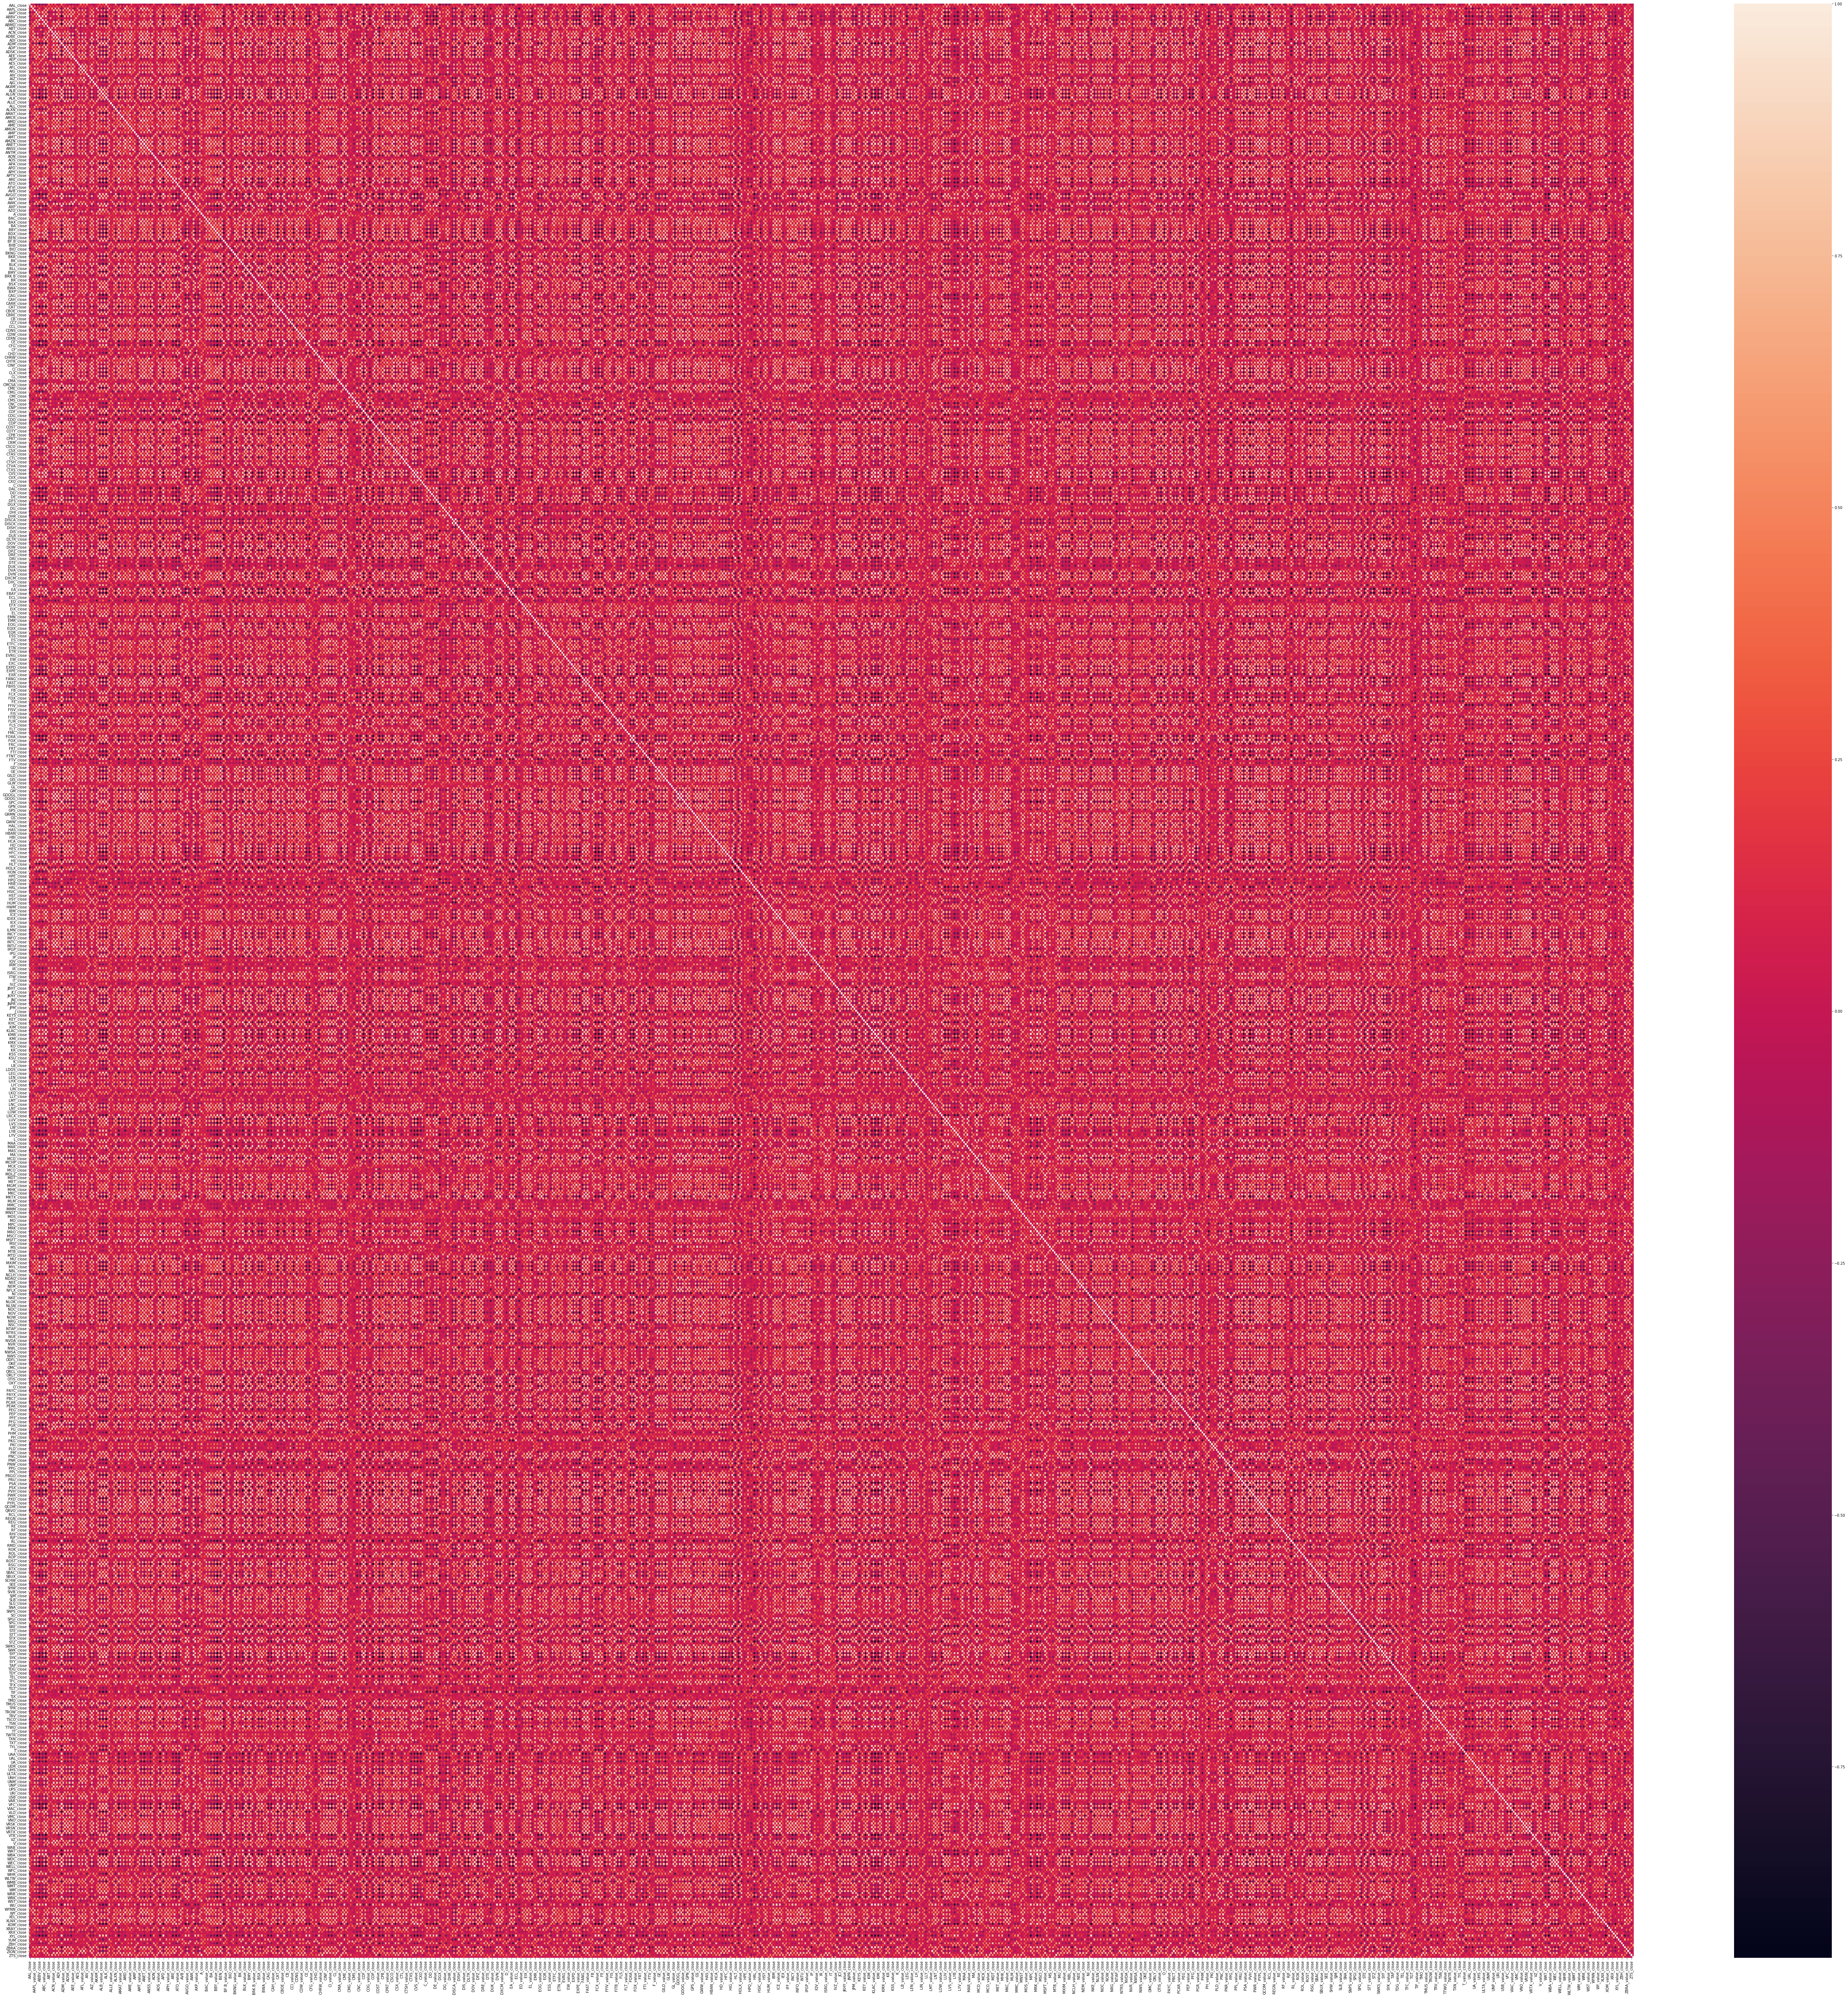

In [67]:
import seaborn as sns

plt.figure(figsize=(100,100))
sns.heatmap(interval_df[interval_df.columns[interval_df.columns.str.contains('close')]].corr())

So far, we have cut the data into intervals by computing the 'global' (here referencing the S&P500) volume * share price on a cumulative basis. We have then computed the new open, high, low, close, volume, and value statistics for each new 'bar'. In essence, we have forgotten about time as we normally think of it, and replaced it with a form of 'time' that measures the flow of dollars. 

Our hope in doing so would be that returns follow a more guassian or normal pattern, and are therefore more easily predictible. 

